# Faster R-CNN with FPN training on MOT17



In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g54LXFMURGPR_SrzGq6l9AEcfDRkN4_PGJoFaQpHUKjJpaMmFU9iEw
Mounted at /content/gdrive



## Download torchvision and coco

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [ ]:
%%shell

# Install pycocotools
git clone https://github.com/cocodataset/cocoapi.git
cd cocoapi/PythonAPI
python setup.py build_ext install

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 27.10 MiB/s, done.
Resolving deltas: 100% (576/576), done.
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/pycocotools
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-OGiuun/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 26496, done.
remote: Counting objects: 100% (4104/4104), done.
remote: Compressing objects: 100% (1093/1093), done.
remote: Total 26496 (delta 3131), reused 3807 (delta 2935), pack-reused 22392
Receiving objects: 100% (26496/26496), 34.67 MiB | 26.18 MiB/s, done.
Resolving deltas: 100% (19711/19711), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


### Download MOT 17 Dataset
Download and Save the dataset in drive !
Here I am using dataset from drive

In [ ]:
#%%shell

# download the MOT17 detection challenge
#wget https://motchallenge.net/data/MOT17Det.zip .
# extract it in the current folder
#unzip MOT17Det.zip

#path to dataset
#gdrive/MyDrive/Colab_Notebooks/faster_rcnn_fpn_training_mot_17/

--2020-08-20 17:21:06--  https://motchallenge.net/data/MOT17Det.zip
Resolving motchallenge.net (motchallenge.net)... 131.159.19.34, 2a09:80c0:18::1034
Connecting to motchallenge.net (motchallenge.net)|131.159.19.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1952547113 (1.8G) [application/zip]
Saving to: ‘MOT17Det.zip’

MOT17Det.zip          5%[>                   ] 109.49M  10.5MB/s    eta 3m 22s 

Let's have a look at the dataset and how it is layed down.

The data is structured as follows


## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [ ]:
import configparser
import csv
import os
import os.path as osp
import pickle
from PIL import Image
import numpy as np
import scipy
import torch


class MOT17ObjDetect(torch.utils.data.Dataset):
    """ Data class for the Multiple Object Tracking Dataset
    """

    def __init__(self, root, transforms=None, vis_threshold=0.25):
        self.root = root  #root = dataset path "gdrive/MyDrive/Colab_Notebooks/faster_rcnn_fpn_training_mot_17/train"
        self.transforms = transforms # transforms if not none, it will contain tensors of images
        self._vis_threshold = vis_threshold
        self._classes = ('background', 'pedestrian') # classes for prediction
        self._img_paths = []  # all images path

        for f in os.listdir(root):  # for every f i.e., MOT17-02,MOT17-04, etc present in train or test dataset folder
            path = os.path.join(root, f) # joining train + MOT17-02
            config_file = os.path.join(path, 'seqinfo.ini')  # seqinfo.ini has information about the dataset....

            assert os.path.exists(config_file), \
                'Path does not exist: {}'.format(config_file) # checking if path exists

            config = configparser.ConfigParser()
            config.read(config_file) # reading config file i.e., seqinfo.ini
            seq_len = int(config['Sequence']['seqLength'])  #fetching seqlength
            im_width = int(config['Sequence']['imWidth'])  #fetching image width
            im_height = int(config['Sequence']['imHeight'])  #fetching image height
            im_ext = config['Sequence']['imExt']  #fetching file ext i.e., jpg or png
            im_dir = config['Sequence']['imDir']  #image directory i.e., img1

            _imDir = os.path.join(path, im_dir)  # joining image dir path i.e., gdrive/MyDrive/Colab_Notebooks/faster_rcnn_fpn_training_mot_17/train/MOT17-02/img1

            for i in range(1, seq_len + 1):  # for all imgs
                img_path = os.path.join(_imDir, f"{i:06d}{im_ext}")  # 6 digits's of 0 + i and .jpg 
                assert os.path.exists(img_path), \
                    'Path does not exist: {img_path}'  #check if path exists
                # self._img_paths.append((img_path, im_width, im_height))
                self._img_paths.append(img_path)  #appending img path so _img_paths = ["train/MOT17-02/img1/000001.jpg,..."]

    @property
    def num_classes(self):
        return len(self._classes) # number of classes i.e., 2

    def _get_annotation(self, idx):  # to obtain target for an img
        """
        """

        if 'test' in self.root:  # if it is a test dataset, then return empty target
          
            num_objs = 0
            boxes = torch.zeros((num_objs, 4), dtype=torch.float32)

            return {'boxes': boxes,
                'labels': torch.ones((num_objs,), dtype=torch.int64),
                'image_id': torch.tensor([idx]),
                'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
                'iscrowd': torch.zeros((num_objs,), dtype=torch.int64),
                'visibilities': torch.zeros((num_objs), dtype=torch.float32)}
                
        img_path = self._img_paths[idx]  #idx = image index which is given through param
        # ex for img_path is "gdrive/MyDrive/Colab_Notebooks/faster_rcnn_fpn_training_mot_17/test/MOT17-01/img1/000001.jpg"
        file_index = int(os.path.basename(img_path).split('.')[0]) # for above ex, it is 1 
        
        gt_file = os.path.join(os.path.dirname(
            os.path.dirname(img_path)), 'gt', 'gt.txt')  # ground truth

        assert os.path.exists(gt_file), \
            'GT file does not exist: {}'.format(gt_file)  # check if gt exists

        bounding_boxes = []

        with open(gt_file, "r") as inf:  # open gt file for reading
            reader = csv.reader(inf, delimiter=',')
            for row in reader:
                visibility = float(row[8])
                # check if the current row is the file we are looking for or not
                if int(row[0]) == file_index and int(row[6]) == 1 and int(row[7]) == 1 and visibility >= self._vis_threshold:
                    bb = {}
                    bb['bb_left'] = int(row[2])  #912
                    bb['bb_top'] = int(row[3])    #484
                    bb['bb_width'] = int(row[4])  #97
                    bb['bb_height'] = int(row[5]) #109
                    bb['visibility'] = float(row[8])  #1

                    bounding_boxes.append(bb)

        num_objs = len(bounding_boxes)
        # torch.zeros(*size, *, dtype=None) = sequence of integers defining the shape of the output tensor 
        # ex = torch.zeros(2, 3) = tensor([[ 0.,  0.,  0.], [ 0.,  0.,  0.]])
        boxes = torch.zeros((num_objs, 4), dtype=torch.float32) 
        visibilities = torch.zeros((num_objs), dtype=torch.float32)
        
        for i, bb in enumerate(bounding_boxes): # since for one img, bounding_box has only one bb
            # Make pixel indexes 0-based, should already be 0-based (or not)
            x1 = bb['bb_left'] - 1
            y1 = bb['bb_top'] - 1
            # This -1 accounts for the width (width of 1 x1=x2)
            x2 = x1 + bb['bb_width'] - 1
            y2 = y1 + bb['bb_height'] - 1

            boxes[i, 0] = x1
            boxes[i, 1] = y1
            boxes[i, 2] = x2
            boxes[i, 3] = y2
            visibilities[i] = bb['visibility']
            
        return {'boxes': boxes,
                'labels': torch.ones((num_objs,), dtype=torch.int64),
                'image_id': torch.tensor([idx]),
                'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
                'iscrowd': torch.zeros((num_objs,), dtype=torch.int64),
                'visibilities': visibilities,}

    def __getitem__(self, idx):
        # load images ad masks
        img_path = self._img_paths[idx]
        # mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")

        target = self._get_annotation(idx) # fetching target for given img

        if self.transforms is not None:  # if transforms given, then do below
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self._img_paths)  # number of imgs
    
    def write_results_files(self, results, output_dir): # writing results to output file
        """Write the detections in the format for MOT17Det sumbission

        all_boxes[image] = N x 5 array of detections in (x1, y1, x2, y2, score)

        Each file contains these lines:
        <frame>, <id>, <bb_left>, <bb_top>, <bb_width>, <bb_height>, <conf>, <x>, <y>, <z>

        Files to sumbit:
        ./MOT17-01.txt
        ./MOT17-02.txt
        ./MOT17-03.txt
        ./MOT17-04.txt
        ./MOT17-05.txt
        ./MOT17-06.txt
        ./MOT17-07.txt
        ./MOT17-08.txt
        ./MOT17-09.txt
        ./MOT17-10.txt
        ./MOT17-11.txt
        ./MOT17-12.txt
        ./MOT17-13.txt
        ./MOT17-14.txt
        """

        #format_str = "{}, -1, {}, {}, {}, {}, {}, -1, -1, -1"

        files = {}
        for image_id, res in results.items(): 
            path = self._img_paths[image_id]
            img1, name = osp.split(path)
            # get image number out of name
            frame = int(name.split('.')[0])
            # smth like /train/MOT17-09
            tmp = osp.dirname(img1)
            # get the folder name of the sequence and split it
            tmp = osp.basename(tmp).split('-')
            # Now get the output name of the file
            out = tmp[0]+'-'+tmp[1]+'.txt'
            outfile = osp.join(output_dir, out)  # output file path like MOT17-02.txt

            # check if out in keys and create empty list if not
            if outfile not in files.keys():
                files[outfile] = []

            for box, score in zip(res['boxes'], res['scores']):
                x1 = box[0].item()
                y1 = box[1].item()
                x2 = box[2].item()
                y2 = box[3].item()
                files[outfile].append([frame, -1, x1, y1, x2 - x1, y2 - y1, score.item(), -1, -1, -1])

        for k, v in files.items():  # k is outfile
            with open(k, "w") as of: # of is output file opened for writing
                writer = csv.writer(of, delimiter=',')
                for d in v: 
                    writer.writerow(d)

    def print_eval(self, results, ovthresh=0.5):  # for printing the result of our detection such as tp, fp, prec, rec, ap
        """Evaluates the detections

        all_boxes[cls][image] = N x 5 array of detections in (x1, y1, x2, y2, score)
        """

        if 'test' in self.root:
            print('No GT data available for evaluation.')
            return
            
        # Lists for tp and fp in the format tp[cls][image]
        tp = [[] for _ in range(len(self._img_paths))]
        fp = [[] for _ in range(len(self._img_paths))]

        npos = 0
        gt = []
        gt_found = []

        for idx in range(len(self._img_paths)):
            annotation = self._get_annotation(idx)
            bbox = annotation['boxes'][annotation['visibilities'].gt(self._vis_threshold)]
            found = np.zeros(bbox.shape[0])
            gt.append(bbox.cpu().numpy())
            gt_found.append(found)

            npos += found.shape[0]

        # Loop through all images
        # for res in results:
        for im_index, (im_gt, found) in enumerate(zip(gt, gt_found)):
            # Loop through dets and mark TPs and FPs
            
            im_det = results[im_index]['boxes'].cpu().numpy()

            im_tp = np.zeros(len(im_det)) # img's TP
            im_fp = np.zeros(len(im_det)) # img's FP
            for i, d in enumerate(im_det):
                ovmax = -np.inf

                if im_gt.size > 0:
                    # compute overlaps i.e, IoU
                    # intersection
                    ixmin = np.maximum(im_gt[:, 0], d[0])
                    iymin = np.maximum(im_gt[:, 1], d[1])
                    ixmax = np.minimum(im_gt[:, 2], d[2])
                    iymax = np.minimum(im_gt[:, 3], d[3])
                    iw = np.maximum(ixmax - ixmin + 1., 0.)
                    ih = np.maximum(iymax - iymin + 1., 0.)
                    inters = iw * ih

                    # union
                    uni = ((d[2] - d[0] + 1.) * (d[3] - d[1] + 1.) +
                            (im_gt[:, 2] - im_gt[:, 0] + 1.) *
                            (im_gt[:, 3] - im_gt[:, 1] + 1.) - inters)

                    overlaps = inters / uni
                    ovmax = np.max(overlaps)
                    jmax = np.argmax(overlaps)

                if ovmax > ovthresh:
                    if found[jmax] == 0:
                        im_tp[i] = 1.
                        found[jmax] = 1.
                    else:
                        im_fp[i] = 1.
                else:
                    im_fp[i] = 1.

            tp[im_index] = im_tp
            fp[im_index] = im_fp

        # Flatten out tp and fp into a numpy array
        i = 0
        for im in tp:
            if type(im) != type([]):
                i += im.shape[0]

        tp_flat = np.zeros(i)
        fp_flat = np.zeros(i)

        i = 0
        for tp_im, fp_im in zip(tp, fp):
            if type(tp_im) != type([]):
                s = tp_im.shape[0]
                tp_flat[i:s+i] = tp_im
                fp_flat[i:s+i] = fp_im
                i += s

        tp = np.cumsum(tp_flat)
        fp = np.cumsum(fp_flat)
        # recall
        rec = tp / float(npos)
        # avoid divide by zero in case the first detection matches a difficult
        # ground truth (probably not needed in my code but doesn't harm if left)
        prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
        tmp = np.maximum(tp + fp, np.finfo(np.float64).eps)

        # correct AP calculation
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])

        tp, fp, prec, rec, ap = np.max(tp), np.max(fp), prec[-1], np.max(rec), ap
        
        print(f"AP: {ap} Prec: {prec} Rec: {rec} TP: {tp} FP: {fp}")


# Plot Method
Defining plot() method for plotting the image with corresponding BB

In [ ]:
import matplotlib.pyplot as plt
import transforms as T

# dataset = MOT17ObjDetect('gdrive/MyDrive/Colab_Notebooks/faster_rcnn_fpn_training_mot_17/train') 
# "gdrive/MyDrive/Colab_Notebooks/faster_rcnn_fpn_training_mot_17/train"
# img, target = dataset[0]

def plot(img, boxes):
  fig, ax = plt.subplots(1, dpi=96)

  img = img.mul(255).permute(1, 2, 0).byte().numpy()
  width, height, _ = img.shape
    
  ax.imshow(img, cmap='gray')
  fig.set_size_inches(width / 80, height / 80)

  for box in boxes:
      rect = plt.Rectangle(
        (box[0], box[1]),
        box[2] - box[0],
        box[3] - box[1],
        fill=False,
        linewidth=1.0)
      ax.add_patch(rect)

  plt.axis('off')
  plt.show()

# img, target = T.ToTensor()(img, target)
# plot(img, target['boxes'])

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_detection_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.nms_thresh = 0.3
    
    return model

DATASETS

In [ ]:
from engine import train_one_epoch, evaluate
import utils

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
# use our dataset and defined transformations
# dataset = MOT17ObjDetect('gdrive/MyDrive/Colab_Notebooks/faster_rcnn_fpn_training_mot_17/train', get_transform(train=True))
dataset_no_random = MOT17ObjDetect('gdrive/MyDrive/Colab_Notebooks/faster_rcnn_fpn_training_mot_17/train', get_transform(train=False))
# dataset_test = MOT17ObjDetect('test', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders

# data_loader = torch.utils.data.DataLoader(
#     dataset, batch_size=2, shuffle=True, num_workers=4,
#     collate_fn=utils.collate_fn)

data_loader_no_random = torch.utils.data.DataLoader(
    dataset_no_random, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# data_loader_test = torch.utils.data.DataLoader(
#     dataset_test, batch_size=1, shuffle=False, num_workers=4,
#     collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


INIT MODEL AND OPTIM

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# get the model using our helper function
model = get_detection_model(dataset_no_random.num_classes)
# move model to the right device
# It is necessary to have both the model, and the data on the same device, either CPU or GPU, for the model to process data. 
# Data on CPU and model on GPU, or vice-versa, will result in a Runtime error.
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.00001,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=10,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


TRAINING

In [ ]:
def evaluate_and_write_result_files(model, data_loader):
  model.eval()
  results = {}
  for imgs, targets in data_loader:
    imgs = [img.to(device) for img in imgs]

    with torch.no_grad(): # Context-manager that disabled the gradient calculation.
        preds = model(imgs) 
    
    for pred, target in zip(preds, targets):
        results[target['image_id'].item()] = {'boxes': pred['boxes'].cpu(),
                                              'scores': pred['scores'].cpu()}

  data_loader.dataset.print_eval(results)  
  data_loader.dataset.write_results_files(results, 'gdrive/MyDrive/Colab_Notebooks/faster_rcnn_fpn_training_mot_17/resnet50/')

# evaluate_and_write_result_files(model, data_loader_test)
evaluate_and_write_result_files(model, data_loader_no_random)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AP: 0.029860279441487787 Prec: 0.06320050867417387 Rec: 0.39181293369875797 TP: 33596.0 FP: 497982.0


In [ ]:
num_epochs = 27

for epoch in range(1, num_epochs + 1):
    train_one_epoch(model, optimizer, data_loader_no_random, device, epoch, print_freq=200)
    # update the learning rate
    # lr_scheduler.step()
    # evaluate on the test dataset
    if epoch % 3 == 0:
      evaluate_and_write_result_files(model, data_loader_no_random)
      torch.save(model.state_dict(), f"gdrive/MyDrive/Colab_Notebooks/faster_rcnn_fpn_training_mot_17/model_epoch_{epoch}.model")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1]  [   0/5316]  eta: 1:48:58  lr: 0.000010  loss: 1.9305 (1.9305)  loss_classifier: 0.7894 (0.7894)  loss_box_reg: 1.0228 (1.0228)  loss_objectness: 0.0521 (0.0521)  loss_rpn_box_reg: 0.0662 (0.0662)  time: 1.2301  data: 0.6325  max mem: 1377
Epoch: [1]  [ 200/5316]  eta: 0:36:17  lr: 0.000010  loss: 1.3798 (1.5716)  loss_classifier: 0.4558 (0.5424)  loss_box_reg: 0.8367 (0.9039)  loss_objectness: 0.0351 (0.0566)  loss_rpn_box_reg: 0.0487 (0.0687)  time: 0.4246  data: 0.0100  max mem: 1641
Epoch: [1]  [ 400/5316]  eta: 0:34:51  lr: 0.000010  loss: 1.2317 (1.4420)  loss_classifier: 0.3868 (0.4834)  loss_box_reg: 0.7753 (0.8456)  loss_objectness: 0.0392 (0.0516)  loss_rpn_box_reg: 0.0263 (0.0614)  time: 0.4236  data: 0.0093  max mem: 1641
Epoch: [1]  [ 600/5316]  eta: 0:33:25  lr: 0.000010  loss: 1.3296 (1.3920)  loss_classifier: 0.3673 (0.4505)  loss_box_reg: 0.7278 (0.8177)  loss_objectness: 0.0466 (0.0485)  loss_rpn_box_reg: 0.1693 (0.0754)  time: 0.4226  data: 0.0102  max me

KeyboardInterrupt: ignored

QUALITATIVE TESTING

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


gdrive/MyDrive/Colab_Notebooks/faster_rcnn_fpn_training_mot_17/train/MOT17-02/img1/000001.jpg


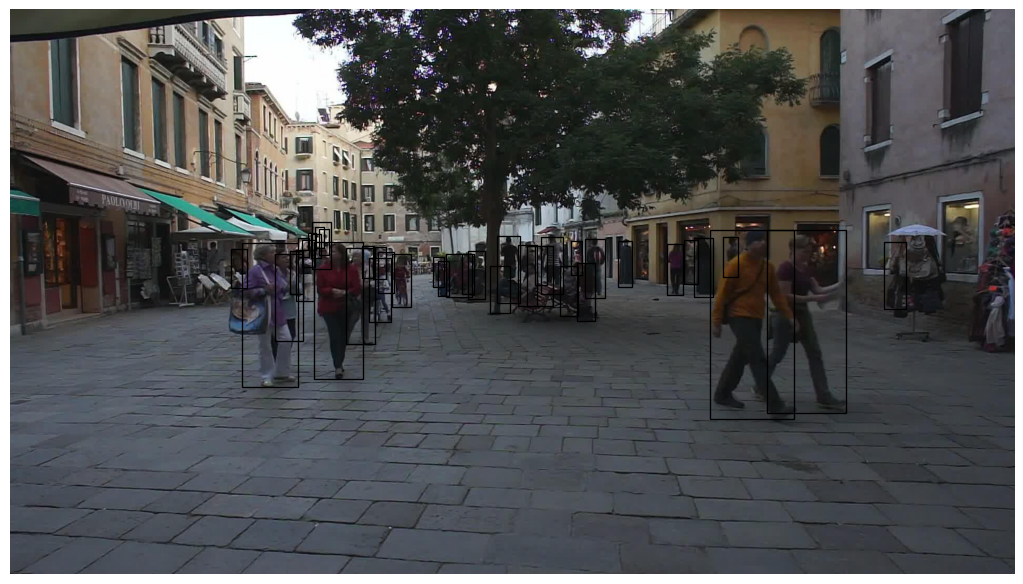

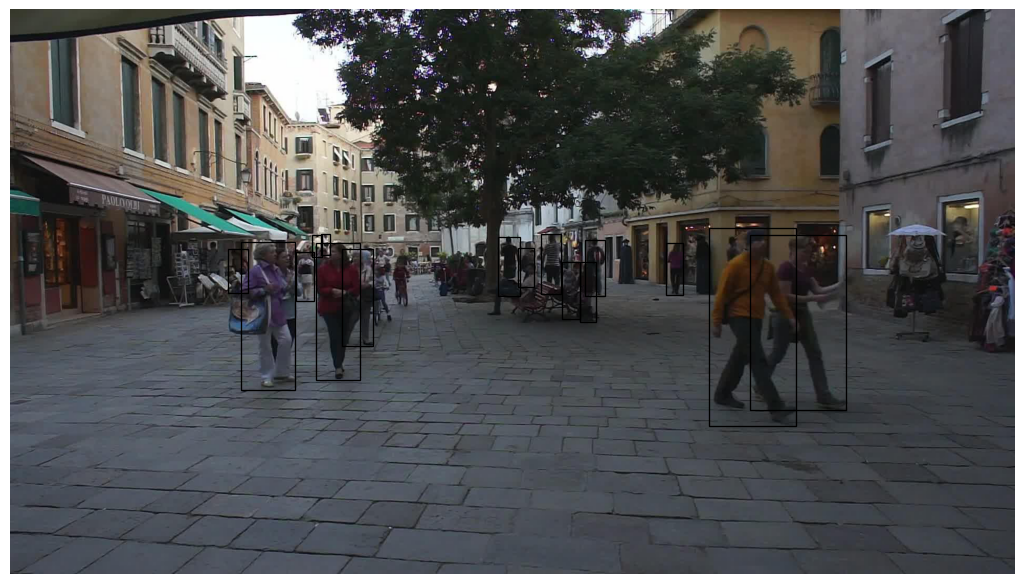

In [ ]:
#from sklearn.metrics import accuracy_score
# pick one image from the test set
dataset = MOT17ObjDetect('gdrive/MyDrive/Colab_Notebooks/faster_rcnn_fpn_training_mot_17/train', get_transform(train=False))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

for imgs, target in data_loader:
    print(dataset._img_paths[0])
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([imgs[0].to(device)])[0]
    

    plot(imgs[0], prediction['boxes'])
    plot(imgs[0], target[0]['boxes'])
    break


# Testing

In [ ]:
# %%shell

# ls
# ls train
# ls test

# ls train/MOT17-02/
# ls train/MOT17-02/img1/


Here is one example of an image in the dataset, with its corresponding instance segmentation mask

In [ ]:
# from PIL import Image
# Image.open('train/MOT17-02/img1/000001.jpg')